In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import torch 
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from PIL import Image 
import os

In [4]:
class CatsVsDogsDataset(Dataset):
    def __init__(self, root_dir, train = True, val = False, test = False, transform=None):
        super(CatsVsDogsDataset, self).__init__()
        self.root_dir = root_dir 
        self.transform = transform
        self.training_file = self.root_dir + "train"
        self.testing_file = self.root_dir + "test"
        self.train = train
        self.val = val
        self.test = test
        
        if self.train:
            self.data = os.listdir(self.training_file)[int(len(os.listdir(self.training_file))*0.1):]
        elif self.val: 
            self.data = os.listdir(self.training_file)[:int(len(os.listdir(self.training_file))*0.1)]
        else:
            self.data = os.listdir(self.testing_file)
            
        if self.train or self.val:
            self.targets = self.label_img(self.data)
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        if self.train or self.val:
            img, target = self.data[index], self.targets[index]
            img = Image.open(os.path.join(self.training_file, img))
        else:
            img = self.data[index]
            img = Image.open(os.path.join(self.testing_file, img))

        if self.transform is not None:
            img = self.transform(img)
        
        if self.train or self.val:
            return img, torch.tensor(target)
        else:
            return img
    
    def label_img(self, data_files):
        labels = []
        for files in data_files:
            word_label = files.split('.')[-3]
            if word_label == 'cat':  # cat -> 0
                labels.append(0.0)
            elif word_label == 'dog': # dog -> 1
                labels.append(1.0)
        return labels

In [3]:
transform_train  = transforms.Compose([transforms.Resize((227,227)),
                                       transforms.RandomApply([
                                           transforms.RandomChoice([transforms.ColorJitter(hue=.05, saturation=.05),
                                                                    transforms.RandomRotation(20, resample=Image.NEAREST),
                                                                    transforms.RandomAffine(0, shear=0.2, resample=Image.NEAREST)])],
                                           p = 0.5),
                                       transforms.RandomHorizontalFlip(p= 0.4),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform_val  = transforms.Compose([transforms.Resize((227,227)),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [5]:
trainset = CatsVsDogsDataset(root_dir = 'dogs-vs-cats-redux-kernels-edition/', train = True,transform = transform_train)

trainloader = torch.utils.data.DataLoader(trainset, batch_size = 32,
                                         shuffle  = True, num_workers = 0)

valset = CatsVsDogsDataset(root_dir = 'dogs-vs-cats-redux-kernels-edition/', train = False, val = True, transform = transform_val)

valloader = torch.utils.data.DataLoader(valset, batch_size = 32,
                                         shuffle  = False, num_workers = 0)

print("Number of training samples = ",len(trainset))
print("Number of testing samples = ",len(valset))

Number of training samples =  22500
Number of testing samples =  2500


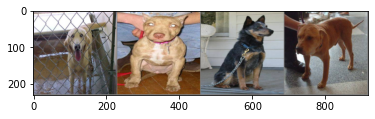

  dog   dog   dog   dog


In [6]:
def imshow(img):
    img = img / 2 + 0.5   
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
classes = {1:"dog", 0:"cat"}

n = 4
dataiter = iter(trainloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images[:n]))
print(' '.join('%5s' % classes[labels[j].item()] for j in range(n)))

In [7]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size = 11, stride = 4)
        self.bn1 = nn.BatchNorm2d(16)
        self.maxpool1 = nn.MaxPool2d(kernel_size = 3, stride = 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size = 5, padding = 2)
        self.bn2 = nn.BatchNorm2d(32)
        self.maxpool2 = nn.MaxPool2d(kernel_size = 3, stride = 2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size = 3, padding = 1)
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64, 32, kernel_size = 3, padding = 1)
        self.bn5 = nn.BatchNorm2d(32)
        self.maxpool3 = nn.MaxPool2d(kernel_size = 3, stride = 2)
        self.fc1 = nn.Linear(1152, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.maxpool2(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.maxpool3(x)
        x = x.view(-1, 1152)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.5)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, 0.5)
        x = self.fc3(x)
        return torch.sigmoid(x)

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cpu


In [9]:
def updateStats(correct, running_loss, phase):
    if phase == 'train':
        Dset = trainset
    else:
        Dset = valset
    acc = 100 * correct/len(Dset)
    epoch_loss = running_loss/len(Dset)
    return acc, epoch_loss

In [10]:
model = AlexNet()
optimizer = optim.Adam(model.parameters(), lr=0.0001,weight_decay = 0.0005)
model.to(device)

criterion = nn.BCELoss()

loss_count_train = []
acc_count_train = []
loss_count_val = []
acc_count_val = []
epochs = 100
for epoch in range(epochs): 
    print("At epoch {}:".format(epoch+1))
    for phase in ['train', 'val']:
        correct = 0.0
        running_loss = 0.0
        if phase == 'train': 
            model.train()
            loader = trainloader
        else:
            model.eval()
            loader = valloader
        for data in loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            labels = labels.unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            ones = torch.ones_like(outputs, dtype = torch.float32)
            zeros = torch.zeros_like(outputs, dtype = torch.float32)
            predicted = torch.where(outputs > 0.5, ones, zeros)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item() * labels.size(0)
        acc, epoch_loss = updateStats(correct,running_loss,phase)
        if phase == 'train':
            acc_count_train.append(acc)
            loss_count_train.append(epoch_loss)
        else:
            acc_count_val.append(acc)
            loss_count_val.append(epoch_loss)
        print(phase+":\n Accuracy = {:.2f}\t Loss = {}".format(acc,epoch_loss))
print('Finished Training')

At epoch 1:
train:
 Accuracy = 66.24	 Loss = 0.6066874654981825
val:
 Accuracy = 85.44	 Loss = 0.38969385480880736
At epoch 2:
train:
 Accuracy = 77.94	 Loss = 0.47264122231801353
val:
 Accuracy = 74.56	 Loss = 0.5525975217819213
At epoch 3:
train:
 Accuracy = 82.52	 Loss = 0.39714350640508866
val:
 Accuracy = 83.20	 Loss = 0.36802413289546965
At epoch 4:
train:
 Accuracy = 84.80	 Loss = 0.35152836367819046
val:
 Accuracy = 90.20	 Loss = 0.24214913492202758
At epoch 5:
train:
 Accuracy = 86.37	 Loss = 0.3223527635044522
val:
 Accuracy = 85.84	 Loss = 0.34722929453849793
At epoch 6:
train:
 Accuracy = 87.68	 Loss = 0.29132364152736134
val:
 Accuracy = 63.64	 Loss = 0.8485974830627442
At epoch 7:
train:
 Accuracy = 88.72	 Loss = 0.26932719984054565
val:
 Accuracy = 91.56	 Loss = 0.2056831280708313
At epoch 8:
train:
 Accuracy = 89.40	 Loss = 0.2547628636466132
val:
 Accuracy = 83.72	 Loss = 0.39561479821205137
At epoch 9:
train:
 Accuracy = 90.14	 Loss = 0.2385409266617563
val:
 Accuracy

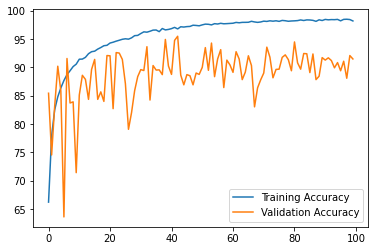

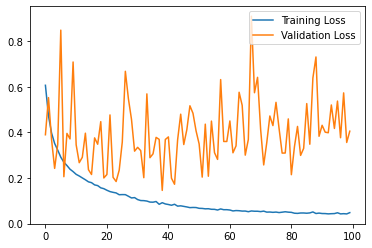

In [11]:
range_epochs = list(range(epochs))
plt.plot(range_epochs,acc_count_train, label = "Training Accuracy")
plt.plot(range_epochs,acc_count_val, label = "Validation Accuracy")
plt.legend()
plt.show()
plt.plot(range_epochs,loss_count_train, label = "Training Loss")
plt.plot(range_epochs,loss_count_val, label = "Validation Loss")
plt.legend()
plt.show()

In [13]:
transform_test  = torchvision.transforms.Compose([torchvision.transforms.Resize((227,227)),
                                             torchvision.transforms.ToTensor(),
                                             torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
testset = CatsVsDogsDataset(root_dir = 'dogs-vs-cats-redux-kernels-edition/', train = False, test = True, transform = transform_test)

testloader = torch.utils.data.DataLoader(testset, batch_size = 32,
                                         shuffle  = False, num_workers = 0)

print("Number of training samples = ",len(testset))

Number of training samples =  12500


In [14]:
result = []
model.eval()
for data in testloader:
    outputs = model(data.to(device))
    result.extend(outputs.view(-1).tolist())

In [15]:
ids = list(range(1, len(testset)+1))
data = pd.DataFrame({"id":ids, "label":result})
data.to_csv('submission.csv', index=False)

In [16]:
#import shutil
#shutil.rmtree('datasets', ignore_errors=False, onerror=None)

PermissionError: [WinError 5] アクセスが拒否されました。: 'dogs-vs-cats-redux-kernels-edition\\sample_submission.csv'

In [17]:
#学習結果の保存
torch.save(model.state_dict(), "././dogs-vs-cats-redux-kernels-edition/model.pth")